# Set Up

In [1]:
#command line items
%load_ext autoreload
%autoreload 2

#python imports
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from copy import copy
from numpy import nan


from pylab import *
import astropy.io.fits as fits
from scipy.io import readsav
from matplotlib.colors import LogNorm
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import matplotlib.patches as patches
#from plot_grids import *
import scipy.integrate as integrate

Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
Yellow = '\033[93m'
Magenta = '\033[95m'
CEND = '\033[0m'

/tmp/ipykernel_13993/989343433.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate Scales

In [2]:
# [OII] and MgII wavelenght
o2 = [3726.03, 3728.82]
mg2 = [2795.5301, 2802.7056]

#Redshift of the source
z = 0.043118

#check that the python library gives the same result as the  manual calculation
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.725)
arcsec_kpc = cosmo.arcsec_per_kpc_proper(z) 
deg_kpc = arcsec_kpc / 60. /60. # degree size of 1 kpc

print(Green + 'Check using FlatLambdaCDM, scale:' + CEND, arcsec_kpc, 1/arcsec_kpc)

#Set some constants
h0 = 67.4
Om = 0.315
Ol = 1 - Om
c_light = 299792.458

#Estimate the Angular Diameter Distance 
def func(x):
    return 1/np.sqrt( Om * (1+x)**3 + Ol)

result = integrate.quad(lambda x: func(x), 0, z)
da = c_light/h0*1/(1+z)* (result[0])
print(Red + 'Angular Diameter Distance is' + CEND, da, Red + 'Mpc' + CEND)

# 4.84814e-6 is rad in arcsec, 1000 is to have the scale in kpc
x = da * 1000 * 4.84814e-6

# 8.096e-5 is the pixel scale along slice, 3600 is to convert it in arcsec (0.291456)
pixel_size = 8.096e-5 * 3600
pixel_scale = x * pixel_size


arcsec_pixel =  pixel_scale / x

print (Blue + "Scale: 1 arcsec is" + CEND, x, Blue + "kpc" + CEND)
print (Magenta + "Scale: 1 pixel is" + CEND, pixel_scale, Magenta + "kpc" + CEND)
print (Cyan + "FOV for z" + CEND, z, Cyan + "is" + CEND, 16.5 * x, 'x', 20.4 * x, Cyan + "kpc" + CEND,)
print (Yellow + "Scale: 1 pixel is" + CEND, arcsec_pixel, Yellow + "arcsec" + CEND)


Check using FlatLambdaCDM, scale: 1.1335033945669866 arcsec / kpc 0.8822205604262997 kpc / arcsec
Angular Diameter Distance is 181.9717830858933 Mpc
Scale: 1 arcsec is 0.8822246804500427 kpc
Scale: 1 pixel is 0.25712967646524765 kpc
FOV for z 0.043118 is 14.556707227425704 x 17.99738348118087 kpc
Scale: 1 pixel is 0.291456 arcsec


# Functions to get data for maps

In [17]:
err_thresh = 0.0022 #set the error threshold after exploring the error arrays

def set_sn(arr, arr2):
    sn_cut = np.where(arr < 3) #change here the SN threshold, now set to 3
    arr2[sn_cut] = nan   #if the SN is less than 3, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
   # bad2 = (arr < 1e-26)
   # arr[bad2] = nan
    return arr   

def get_flux_uncorr(arr, arr2):
    f = copy(arr)
    f_err = copy(arr2)
    
    f = set_bad(f)
    f_err = set_bad(f_err)  

    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
        
    sn = f/f_err
    f = set_sn(sn,f)  
    return f

def get_err_flux(arr):
    f_err = copy(arr)
    f_err = set_bad(f_err)  
    
    return f_err

    
def get_v50(arr, arr2, arr3):
    f = copy(arr)
    f_err = copy(arr2)

    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3)
    v = set_bad(v)
    v = set_sn(sn,v)
    return v 

def get_vsig(arr, arr2, arr3):
    f = copy(arr)
    f_err = copy(arr2)
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3)
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v02(arr, arr2, arr3):
    f = copy(arr)
    f_err = copy(arr2)
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3)
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v98(arr, arr2, arr3):
    f = copy(arr)
    f_err = copy(arr2)
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3)
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(arr, arr2):
    f = copy(arr)
    f_err = copy(arr2)
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

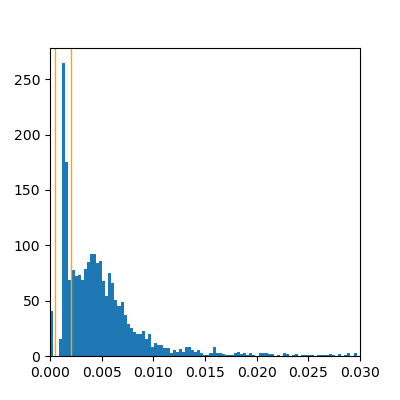

In [9]:
# determine err_thresh
with fits.open('F05189_full_2comp_flipped.fits') as hdul:
    %matplotlib widget
    figure(figsize=(4,4))
    ax = subplot(111)
    plt.xlim(0,0.03)

    index = np.where(hdul[1].data['err_fc2'] < 0.03)
    test_list = hdul[1].data['err_fc2'][index]
    test_list = test_list.flatten()
    # test_list = [x for x in test_list if str(x) != 'nan']

    ax.hist(test_list,bins=100)
    ax.axvline(x = 0.0005, c='orange', lw=1, ls='-')
    ax.axvline(x = 0.002, c='orange', lw=1, ls='-')
    # savefig('o2_errorhist_fc2_fromFITS.pdf')

# Functions to plot kinematics maps

In [37]:
def plot_kin(f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, spx=False, rec= False):
    figure(figsize=(5,5))
    
    v50_line = get_v50(f_temp, err_f_temp, v50_temp)
    vsig_line = get_vsig(f_temp, err_f_temp, vsig_temp)
    v02_line = get_v02(f_temp, err_f_temp, v02_temp)
    v98_line = get_v98(f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    imshow(v50_line, origin='lower', cmap='RdBu_r', vmin=-300, vmax=300, interpolation='none')
    ax = gca()
    colorbar()
    ax.title.set_text('$v_{50}\ \mathrm{(km\ s^{-1})}$')
    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
        
    subplot(222)
    imshow(vsig_line, origin='lower', cmap='jet', vmin=0, vmax=350, interpolation='none')#, vmin=200, vmax=350)
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)     
    ax.title.set_text('$\sigma\ \mathrm{(km\ s^{-1})}$')

    subplot(223)
    imshow(v02_line, origin='lower', cmap='RdBu_r', vmin=-600, vmax=600, interpolation='none')
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)     
    ax.title.set_text('$v_{02}\ \mathrm{(km\ s^{-1})}$')

    subplot(224)
    imshow(v98_line, origin='lower', cmap='RdBu_r', vmin=-600, vmax=600, interpolation='none')
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)     
    ax.title.set_text('$v_{98}\ \mathrm{(km\ s^{-1})}$')

    tight_layout()

def plot_kin_c2(f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, spx=False, rec= False):
    figure(figsize=(5,5))
    
    v50_line = get_v50(f_temp, err_f_temp, v50_temp)
    vsig_line = get_vsig(f_temp, err_f_temp, vsig_temp)
    v02_line = get_v02(f_temp, err_f_temp, v02_temp)
    v98_line = get_v98(f_temp, err_f_temp, v98_temp)
          
    subplot(221)
    imshow(v50_line, origin='lower', cmap='RdBu_r', vmin=-800, vmax=800, interpolation='none') #, vmin=-800, vmax=600,
    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)    
    ax.title.set_text('$v_{50}\ \mathrm{(km\ s^{-1})}$')

    subplot(222)
    imshow(vsig_line, origin='lower', cmap='jet', vmin=0, vmax=600, interpolation='none')#, vmin=200, vmax=350) 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('$\sigma\ \mathrm{(km\ s^{-1})}$')
    
    subplot(223)
    imshow(v02_line, origin='lower', cmap='RdBu_r', vmin=-1000, vmax=1000, interpolation='none') 
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)       
    ax.title.set_text('$v_{02}\ \mathrm{(km\ s^{-1})}$')

    subplot(224)
    imshow(v98_line, origin='lower', cmap='RdBu_r', vmin=-2000, vmax=2000, interpolation='none')    
    ax = gca()
    colorbar()
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect)    
    ax.title.set_text('$v_{98}\ \mathrm{(km\ s^{-1})}$')

    tight_layout()

    

# 2comp fit plots

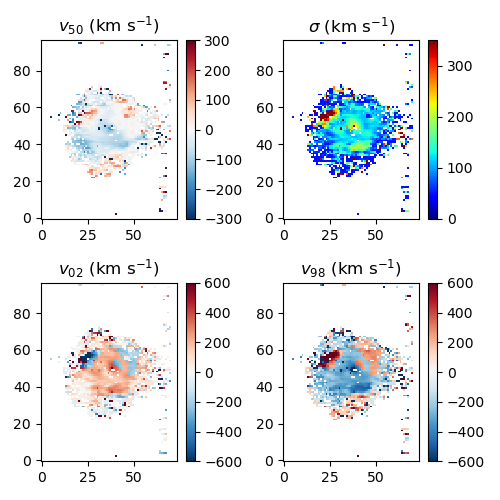

In [29]:
# fc1

%matplotlib widget

with fits.open('F05189_full_2comp_flipped.fits') as hdul:
    fc1 = hdul[1].data['fc1']
    err_fc1 = hdul[1].data['err_fc1']
    v50_c1 = hdul[1].data['v50_c1']
    vsig_c1 = hdul[1].data['vsig_c1']
    v02_c1 = hdul[1].data['v02_c1']
    v98_c1 = hdul[1].data['v98_c1']

    plot_kin(fc1, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1)
    # print('SNR =', round(fc2[5][1][spx_y][spx_x]/err_fc2[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c2[5][1][spx_y][spx_x],2)) 
    # savefig('fc1_2comp_fromFITS_12032022.pdf')

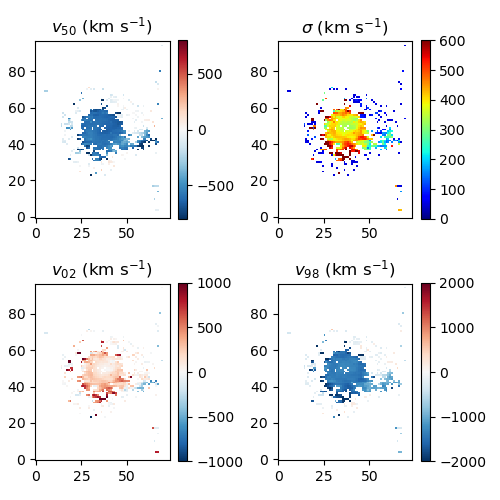

In [39]:
# fc2

%matplotlib widget

with fits.open('F05189_full_2comp_flipped.fits') as hdul:
    fc2 = hdul[1].data['fc2']
    err_fc2 = hdul[1].data['err_fc2']
    v50_c2 = hdul[1].data['v50_c2']
    vsig_c2 = hdul[1].data['vsig_c2']
    v02_c2 = hdul[1].data['v02_c2']
    v98_c2 = hdul[1].data['v98_c2']

    plot_kin_c2(fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2)
    # print('SNR =', round(fc2[5][1][spx_y][spx_x]/err_fc2[5][1][spx_y][spx_x],2), 'v50 =',round(v50_c2[5][1][spx_y][spx_x],2)) 
    # savefig('fc2_2comp_fromFITS_12032022.pdf')

# Compiled fits PDF

In [ ]:
import matplotlib.ticker as ticker

class Spaxel:
    def __init__(self, infile):
        self.xdr = readsav(infile)
        self.xdr_arr = self.xdr['struct']
        self.wave = self.xdr_arr['wave'][0]
        self.spectot = self.xdr_arr['spec'][0]
        self.specstars = self.xdr_arr['cont_dat'][0]
        self.speclines = self.xdr_arr['emlin_dat'][0]
        self.modstars = self.xdr_arr['cont_fit'][0]
        self.modlines = self.xdr_arr['emlin_fit'][0]
        self.specerr = self.xdr_arr['spec_err'][0]
        self.modtot = self.modstars + self.modlines
        if self.xdr_arr['param'] !=0:
            self.ppoff = self.xdr_arr['param'][0][0]
            self.ncomp = self.xdr_arr['param'][0][1].astype(int)
            self.specres = self.xdr_arr['param'][0][2]
            self.rem_lis = []
        else:
            self.ncomp  = 0
        print(self.ncomp)
        
    def cmplin(self, line, comp):
        if comp == 0:
            return 0
        c = 299792.458
        indices = (self.xdr_arr['parinfo'][0]['line'] == line) & (self.xdr_arr['parinfo'][0]['comp'] == comp)
        if indices[0] != -1:
            gausspar = self.xdr_arr['param'][0][indices]
            gaussparRound = np.around(gausspar, decimals = 7)
            gaussparStr = list(map(str, gaussparRound))
            units = ['', ' Ang', ' km/s']
            gaussparFinal = []
            for i in range(len(gaussparStr)):
                gaussparFinal.append(gaussparStr[i] + units[i])
            #print(gaussparFinal)
            
            if len(gausspar) > 0 and not line in self.rem_lis:
                gausspar[2] = sqrt((gausspar[2]*gausspar[1]/c)**2. + self.specres**2.)
                if gausspar[2] == 0 or gausspar[0] == 0:
                    flux = zeros(len(self.wave)) * nan
                else:
                     flux = gaussian(self.wave,*gausspar)
            else:
                flux = zeros(len(self.wave)) * nan
         #   if line == b'[OII]3726':
         #      print('redshift 3726', gausspar[1]/3727.092-1)
         #   elif line== b'[OII]3729':
         #      print('redshift 3729', gausspar[1]/3729.875-1)
         #   else:
         #      print('not [OII] line', line)
        return flux
    
    def plot_lines(self, ax, lines, xmin, xmax):
        ax.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        ax.plot(self.wave, self.modstars + self.modlines, 'C3')
        ax.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        if xmax - xmin <= 40.:
            tick_spacing = 15
        else:
            tick_spacing = 20
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.tick_params(axis='x', which='major', labelsize=6)

    def plot_spec(self, ax, xmin, xmax):
        ax.plot(self.wave, self.speclines, 'k', drawstyle='steps-mid', lw=1.5)
        ax.plot(self.wave, self.modlines, 'C3')
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.2 * amax(yi), 3. * std(yi))
        ymin = 1e-4 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
    def remove_line(self, line):
        iline = zeros(len(self.wave))
        for i in range(1, self.ncomp+1):
            iline += nan_to_num(self.cmplin(line, i))
        self.modlines = self.modlines - iline
        self.modtot = self.modstars + self.modlines
        self.rem_lis.append(line)
        
    def plot_line_vel(self, ax, line, wave, z, vmin, vmax, lw=None):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        ax.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in line:
           for i in range(1,self.ncomp+1):
            style = 'C' + col[i] + '--'
            ax.plot(vel, self.cmplin(l, i), style, lw=1.)
        ax.plot(vel, self.modlines, 'C3', lw=lw)
        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        #ymax = max(1.8 * amax(yi), 3. * amax(erri))
        #ymin =  ymax
        ax.set_xlim(vmin, vmax)
        #ax.set_ylim(ymin, ymax)
        ax.axvline(0,color='k', ls='--', lw=0.5)
        ax.set_yticks(())
        ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        ax.set_ylabel('flux')

    def plot_lines_pdf(self, lines, xmin, xmax, str_x, str_y, pr=False):
        plt.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        plt.plot(self.wave, self.modstars + self.modlines, 'C3')
        plt.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(2.2 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        if pr == True:
            plt.text(3900, ymax*0.9,  str_x + '_' + str_y, fontsize=9)

    def plot_line_vel_pdf(self, line, wave, z, vmin, vmax, sn1=None, sn2=None, lw=None, sn = False):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        plt.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        if self.ncomp!=0:
            col = ['','0','1','2']
            for l in line:
               for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(vel, self.cmplin(l, i), style, lw=1.)
            plt.plot(vel, self.modlines, 'C3', lw=lw)

        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin =  -ymax*0.2
        plt.xlim(vmin, vmax)
        plt.ylim(ymin, ymax)
        plt.axvline(0,color='k', ls='--', lw=0.5)
        if sn == True and self.ncomp!=0:
            plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
            plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)

        #ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        #ax.set_ylabel('flux')        
        
def gaussian(x, A, u, sig):
    return A * exp(-(x-u)**2. / 2. / sig**2.)

def plot_spaxel(ax, spax, lxticks=False, ltitle=False, rem=False):
    spax.plot_lines(ax, [b'[OII]3726', b'[OII]3729'], 3850, 3950)
    ax.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    ax.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)

    if ltitle:
        ax.title.set_text('[OII]3726,9')

 

def plot_spaxel_pdf(spax, str_x, str_y, lxticks=False, ltitle=False, rem=False, pr= False):
    spax.plot_lines_pdf([b'[OII]3726', b'[OII]3729'], 3750, 4050, str_x, str_y, pr)
    plt.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    plt.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)
